<a href="https://colab.research.google.com/github/YolandaMDavis/wildtrack-iqa/blob/task-amenability/task_amenability_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
!pip install gym==0.17.3;
!pip install stable-baselines==2.10.2;
!pip install h5py==3.0.0;
!pip install tensorflow==1.13.1;
!pip install tensorboard==1.13.1;
!pip install Keras==2.2.4;
!pip install Keras-Applications==1.0.8;
!pip install Keras-Preprocessing==1.1.2;
!pip install keras-rl==0.4.2;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Only needed to copy data to local drive can be skipped if zip file is already available in working folder
import shutil

# mount google drive
from google.colab import drive
drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy and extract tar file
shutil.copy(PARENT_DIR + '/data/Annotated_Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# get downstream task model
shutil.copy(PARENT_DIR + '/task-amenability/species/model.pt', 'species_model.pt')

shutil.copy(PARENT_DIR + '/task-amenability/object/model.pt', 'object_model.pt')


Mounted at /content/drive


'object_model.pt'

In [ ]:
# clone the repository and move data file
!git clone https://github.com/YolandaMDavis/wildtrack-iqa.git
!mv Cropped_WildTrack.zip wildtrack-iqa/.
!mv species_model.pt wildtrack-iqa/.
!mv object_model.pt wildtrack-iqa/.
%cd "wildtrack-iqa"
!git checkout task-amenability
!mv species_model.pt taskamenability/taskpredictor/species/model.pt
!mv object_model.pt taskamenability/taskpredictor/objdet/model.pt


Cloning into 'wildtrack-iqa'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 137 (delta 56), reused 92 (delta 27), pack-reused 0
Receiving objects: 100% (137/137), 719.26 KiB | 1.62 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/wildtrack-iqa
Branch 'task-amenability' set up to track remote branch 'task-amenability' from 'origin'.
Switched to a new branch 'task-amenability'


In [ ]:
from zipfile import ZipFile
# extract zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [1]:
%cd "wildtrack-iqa"

import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

with open('taskamenability/taskpredictor/species/class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
device = torch.device('cpu')
model = torch.jit.load('taskamenability/taskpredictor/species/model.pt').to(device)
transforms = A.load('taskamenability/taskpredictor/species/transforms.json')

/content/wildtrack-iqa


In [2]:
from torch.utils import data
import csv
import random
import torch
import yaml
import cv2
import os

from time import process_time
from torch.utils.data import Dataset

root_dir = '/content/wildtrack-iqa'
data_dir = root_dir + '/RAW'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def createImageSamples(img_shape, num_samples):
  x = np.random.rand(num_samples, img_shape[0], img_shape[1], img_shape[2])
  y = np.random.randint(low=0, high=2, size=(num_samples, 1))
  return (x,y)

def generate_data_sets(sample_percentage=1):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]
        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_reference = (image_location, species, animal_class, image, class_index, subjective_score)
              image_reference_list.append(image_reference)
    

    # shuffle then split
    seed = 1234
    random.Random(seed).shuffle(image_reference_list)

    train_index = int(len(image_reference_list) * 0.6 * sample_percentage)
    test_index = -int(len(image_reference_list) * 0.2 * sample_percentage) 
    val_index = test_index * 2

    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]
    return training, validation, testing

def convert_image(img_test):
    image = Image.open(img_test)
    #convert bw to RGB
    bands = image.getbands()
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    image = np.array(image)
    image = transforms(image=image)['image']
    x = torch.from_numpy(image).to(device)
    return x


def transform_images(images):
  x = []
  y = []
  for img in images:
      image_name = img[0]+'/'+img[3]
      image = convert_image(image_name)
      x.append(image)
      y.append(img[4])

  return np.array(x), np.array(y)


In [3]:
# take a percentage of the full data set as a training/test/validation sample
sample_size=.5
train, valid, test = generate_data_sets(sample_size)
x_train, y_train = transform_images(train)
x_val, y_val = transform_images(valid)
x_test, y_test = transform_images(test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


**Execute the below installation only in Colab environment**

In [4]:
from taskamenability.interface import PPOInterface

img_shape = (512,512,3)
task_predictor = model
interface = PPOInterface(x_train, y_train, x_val, y_val, x_test, y_test, task_predictor, img_shape)

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

init vecmonitor:  tmp/
init resultswriter


Instructions for updating:
Use tf.cast instead.


In [ ]:
# skip training
# interface.train(50)


Training started for 50 episodes:
[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1

In [5]:
import shutil

# copy best model to share
#shutil.copy('tmp/best_model.zip', '/content/drive/MyDrive/Wildtrack Group/IQA/task-amenability/best_model.zip')
#interface.load('tmp/best_model.zip')
shutil.copy('/content/drive/MyDrive/Wildtrack Group/IQA/task-amenability/best_model_10_28_2022.zip','tmp/best_model.zip', )
interface.load('tmp/best_model.zip')

Loading a model without an environment, this model cannot be trained until it has a valid environment.


In [6]:
preds = []
class_preds = []
for item in x_test:
  obs = item.permute(2, 0, 1).unsqueeze(dim=0).float()
  y_pred = model(obs)
  y_pred = y_pred.argmax(dim=1).squeeze().item()
  class_preds.append(y_pred)
  preds.append(interface.model.predict(item)[0])

preds = np.rint(np.array(preds).flatten())

In [7]:
# percentage where quality assessment matched the actual outcome (i.e. if deemed 1 it could truly be classified, if deemed 0 it could not be classified)
class_actuals = [ item[4] for item in test]
subjective_quality = [ item[5] for item in test]

accurate_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] == class_actuals[i] and pred_value == 1:
    accurate_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and pred_value == 0:
    accurate_quality_assessment.append(1)
  else:
    accurate_quality_assessment.append(0)

overall_percentage_correct = np.mean(np.array(accurate_quality_assessment)) * 100
overall_percentage_correct

67.23646723646723

In [8]:
# how well does subjective scores do in predicting what images should be used vs not used?
subjective_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subjective_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subjective_quality_assessment.append(1)
  else:
    subjective_quality_assessment.append(0)

subjective_percentage_correct = np.mean(np.array(subjective_quality_assessment)) * 100
subjective_percentage_correct

64.67236467236467

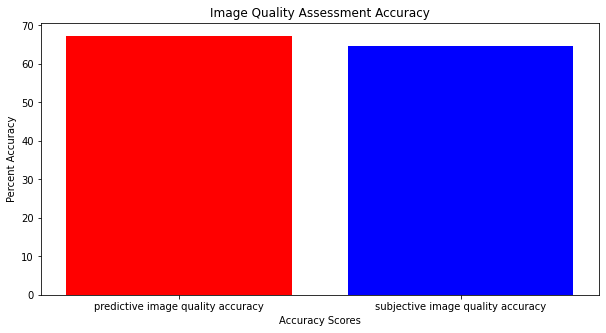

In [9]:
# creating the dataset
data = {'predictive image quality accuracy':overall_percentage_correct, 'subjective image quality accuracy': subjective_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Image Quality Assessment Accuracy")
plt.show()

In [10]:
# out of the total number predicted as high quality, how many actually are high quality? (precision)

matching_quality_assessment = []
for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] == class_actuals[i] and pred_value == 1:
    matching_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and pred_value == 1:
    matching_quality_assessment.append(0)
  else:
    matching_quality_assessment.append(-1)

matching_percentage_correct = np.mean(np.array([value for value in matching_quality_assessment if (value == 0 or value == 1) ])) * 100
matching_percentage_correct


82.1969696969697

In [11]:
# out of the total number predicted as low quality, what percentage are  actually low quality? (recall)
non_matching_quality_assessment = []

for i in range(len(class_preds)):
  pred_value = preds[i]
  if class_preds[i] != class_actuals[i] and pred_value == 0:
    non_matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and pred_value == 0:
    non_matching_quality_assessment.append(0)
  else:
    non_matching_quality_assessment.append(-1)

non_matching_percentage_correct = np.mean(np.array([value for value in non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
non_matching_percentage_correct

21.839080459770116

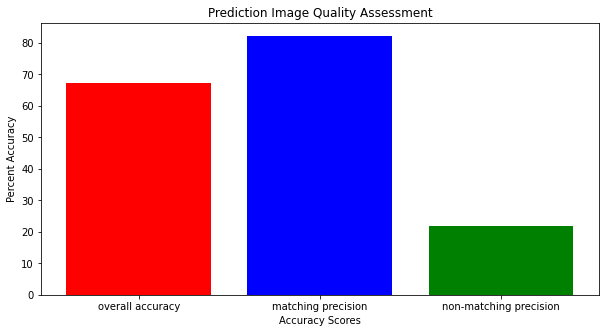

In [12]:
# creating the dataset
data = {'overall accuracy':overall_percentage_correct, 'matching precision':matching_percentage_correct, 'non-matching precision':non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Prediction Image Quality Assessment")
plt.show()

In [13]:
# how well are we doing when predicting classes that truly matched? (precision)

subj_matching_quality_assessment = []

for i in range(len(class_preds)):
  if class_preds[i] == class_actuals[i] and subjective_quality[i] >= 4:
    subj_matching_quality_assessment.append(1)
  elif class_preds[i] != class_actuals[i] and subjective_quality[i] >= 4:
    subj_matching_quality_assessment.append(0)
  else:
    subj_matching_quality_assessment.append(-1)

subj_matching_percentage_correct = np.mean(np.array([value for value in subj_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_matching_percentage_correct

81.56862745098039

In [14]:
# how well are we doing when predicting when not to use an image ? (recall)
subj_non_matching_quality_assessment = []

for i in range(len(class_preds)):

  if class_preds[i] != class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(1)
  elif class_preds[i] == class_actuals[i] and subjective_quality[i] < 4:
    subj_non_matching_quality_assessment.append(0)
  else:
    subj_non_matching_quality_assessment.append(-1)

subj_non_matching_percentage_correct = np.mean(np.array([value for value in subj_non_matching_quality_assessment if (value == 0 or value == 1) ])) * 100
subj_non_matching_percentage_correct

19.791666666666664

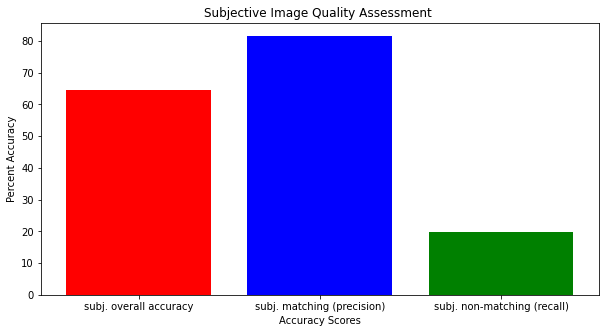

In [15]:
# creating the dataset
data = {'subj. overall accuracy':subjective_percentage_correct, 'subj. matching (precision)': subj_matching_percentage_correct, 'subj. non-matching (recall)': subj_non_matching_percentage_correct}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color = ['red', 'blue','green'])
 
plt.xlabel("Accuracy Scores")
plt.ylabel("Percent Accuracy")
plt.title("Subjective Image Quality Assessment ")
plt.show()

Let's breakdown by species performance

In [16]:
import pandas as pd

overall_species = []
for i in range(len(class_actuals)):
  actual_quality = 1 if class_preds[i] == class_actuals[i] else 0
  subj_quality = 1 if subjective_quality[i] >= 4 else 0
  class_name = class_mapping[class_actuals[i]]
  overall_species.append((class_name, int(preds[i]), subj_quality, actual_quality))

species_accuracy = pd.DataFrame(overall_species, columns =['species', 'predicted_quality', 'subjective_quality', 'actual_performance'])


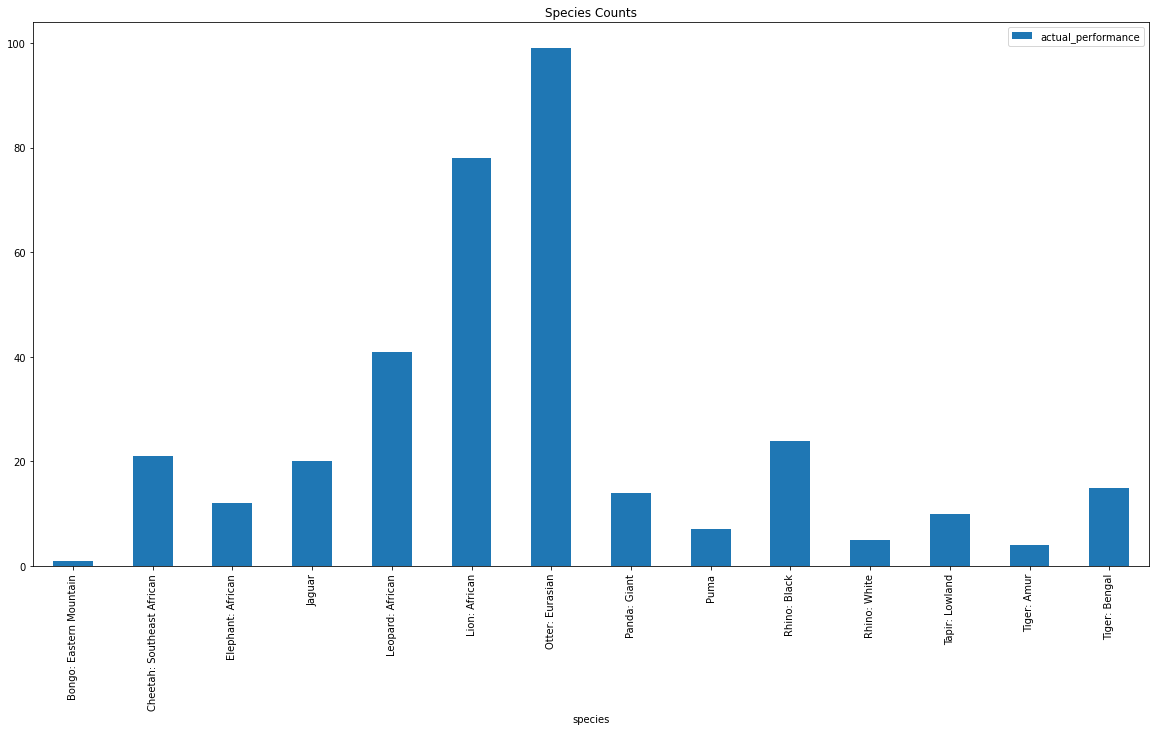

In [17]:
# figure out data distributiong

species_dist = species_accuracy[['species','actual_performance']].groupby(['species']).count()

species_dist.plot(kind = 'bar', figsize=(20,10))
plt.title('Species Counts')
plt.show()

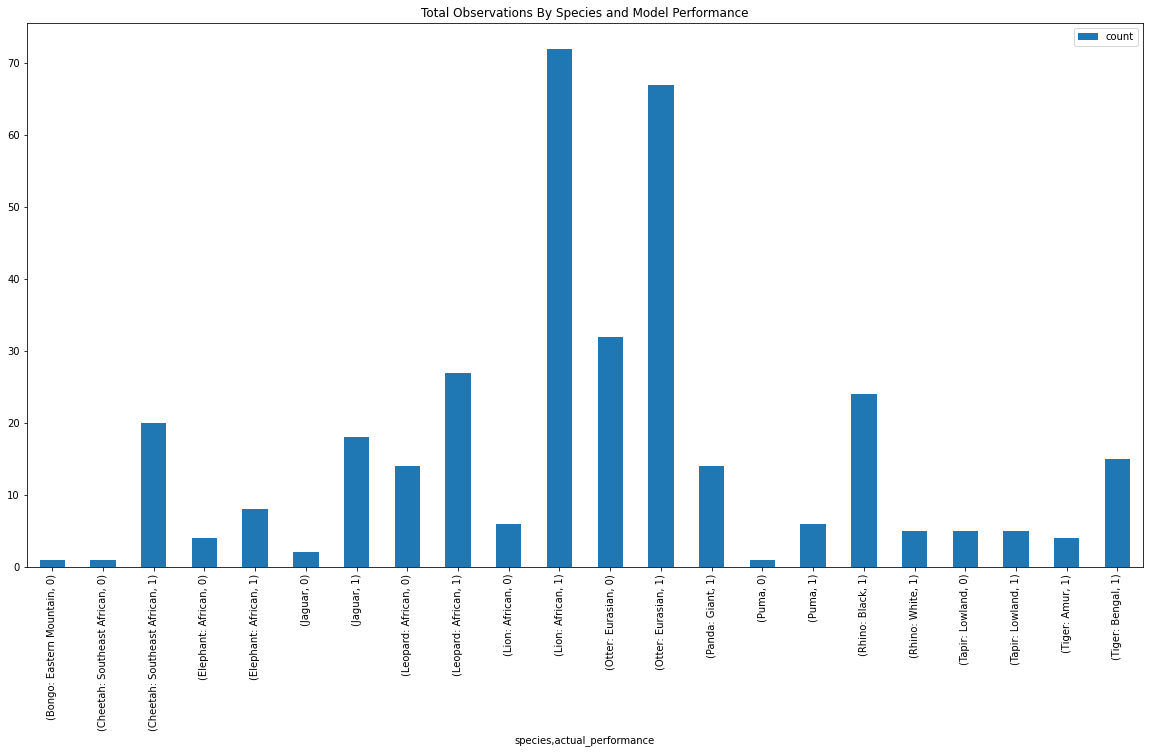

In [18]:
species_accuracy[['species','actual_performance','predicted_quality']].rename(columns={"predicted_quality": "count"}).groupby(['species','actual_performance']).count().plot(kind = 'bar', figsize=(20,10))
plt.title('Total Observations By Species and Model Performance')
plt.show()

In [19]:
species_accuracy['prediction_correct'] = species_accuracy['predicted_quality'] == species_accuracy['actual_performance'] 
species_accuracy['prediction_correct'] = species_accuracy['prediction_correct'].astype(int)

species_accuracy['subjective_correct'] = species_accuracy['subjective_quality'] == species_accuracy['actual_performance']
species_accuracy['subjective_correct'] = species_accuracy['subjective_correct'].astype(int)

species_accuracy['prediction_incorrect'] = species_accuracy['predicted_quality'] != species_accuracy['actual_performance'] 
species_accuracy['prediction_incorrect'] = species_accuracy['prediction_incorrect'].astype(int)

species_accuracy['subjective_incorrect'] = species_accuracy['subjective_quality'] != species_accuracy['actual_performance']
species_accuracy['subjective_incorrect'] = species_accuracy['subjective_incorrect'].astype(int)


In [20]:
subj_overall_accuracy_by_species = species_accuracy[['species','subjective_correct','subjective_incorrect']].groupby(['species']).sum()
pred_overall_accuracy_by_species = species_accuracy[['species','prediction_correct','prediction_incorrect']].groupby(['species']).sum()


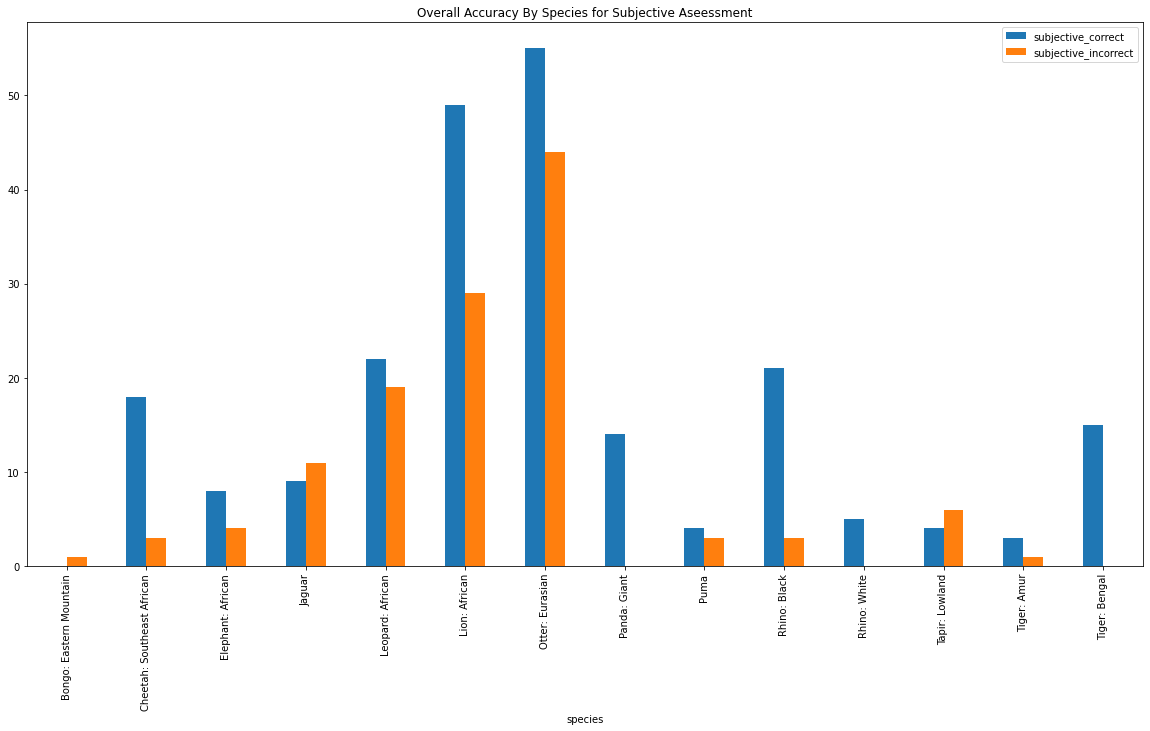

In [21]:
subj_overall_accuracy_by_species.plot(kind = 'bar', figsize=(20,10))
plt.title('Overall Accuracy By Species for Subjective Aseessment')
plt.show()

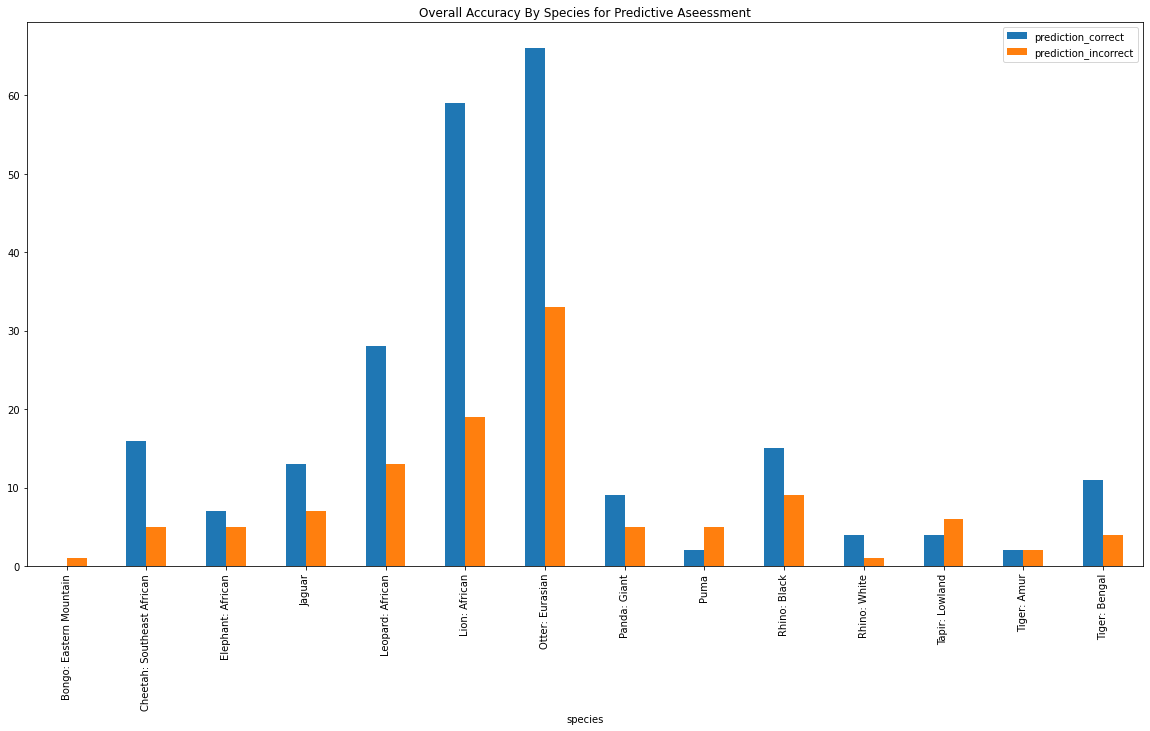

In [22]:
pred_overall_accuracy_by_species.plot(kind = 'bar', figsize=(20,10))
plt.title('Overall Accuracy By Species for Predictive Aseessment')
plt.show()

In [23]:
subj_accuracy_by_species_and_actual_perf = species_accuracy[['species','actual_performance','subjective_correct','subjective_incorrect']].groupby(['species','actual_performance']).sum()
pred_accuracy_by_species_and_actual_perf = species_accuracy[['species','actual_performance','prediction_correct','prediction_incorrect']].groupby(['species','actual_performance']).sum()

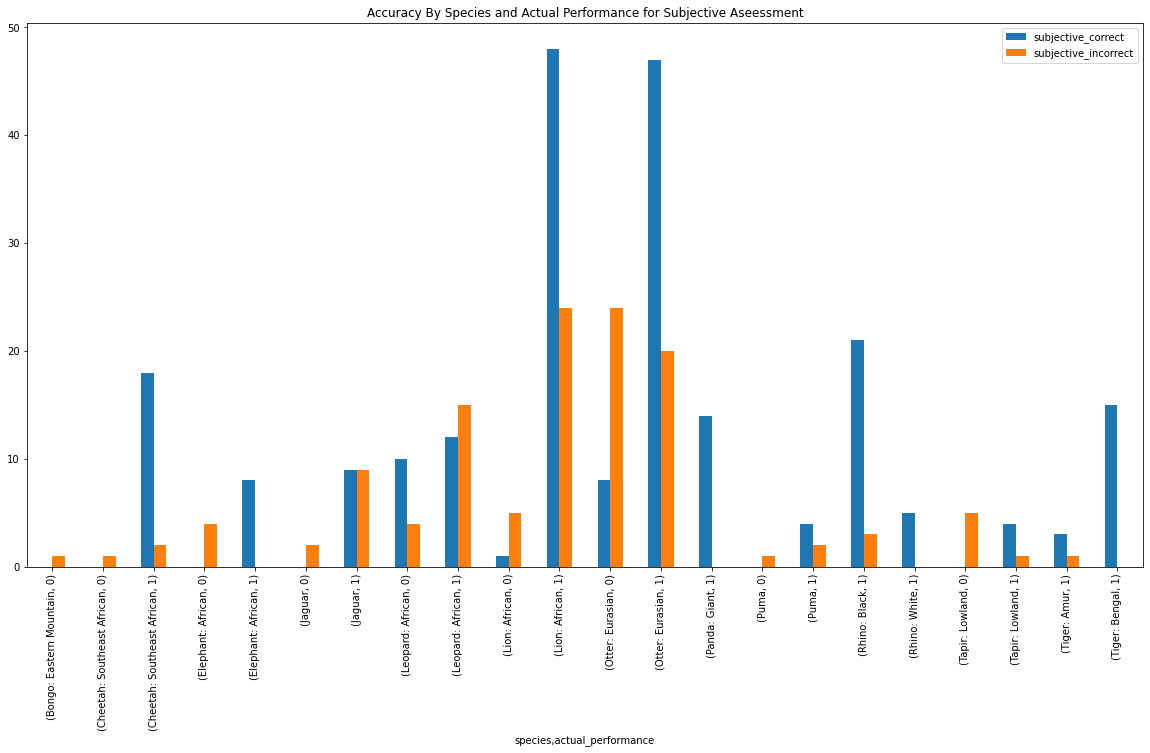

In [24]:
subj_accuracy_by_species_and_actual_perf.plot(kind = 'bar', figsize=(20,10))
plt.title('Accuracy By Species and Actual Performance for Subjective Aseessment')
plt.show()

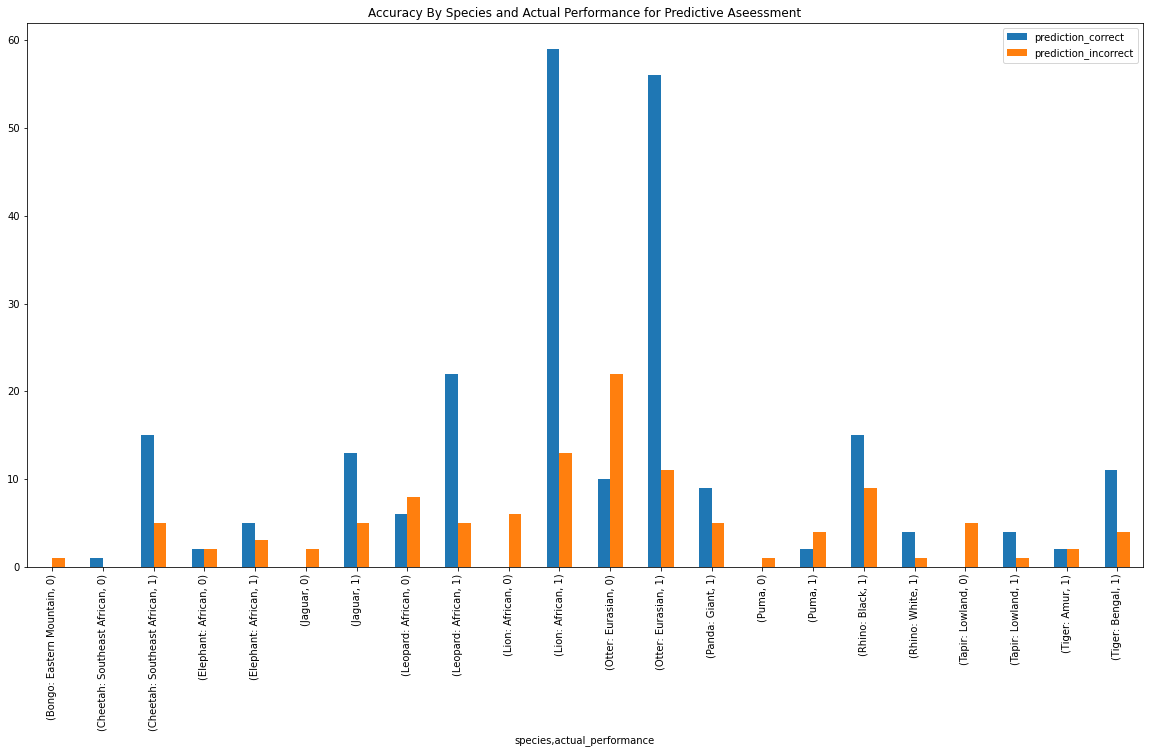

In [25]:
pred_accuracy_by_species_and_actual_perf.plot(kind = 'bar', figsize=(20,10))
plt.title('Accuracy By Species and Actual Performance for Predictive Aseessment')
plt.show()